<a href="https://colab.research.google.com/github/kargaranamir/issue-tagger/blob/main/Data_Exploration_and_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Download

In [ ]:
!wget https://machinehack-be.s3.amazonaws.com/predict_github_issues_embold_sponsored_hackathon/Embold_Participant%27s_Dataset.zip -O data.zip
!unzip ./data.zip 
! mv ./Embold_Participant\'s_Dataset ./data
! rm -rf ./data/sample\ submission.csv
! rm -rf ./data/embold_test.json

## Import Libraries

In [ ]:
# restart runtime after installing is neceassary
! pip install ktrain

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
tqdm.pandas()


import ktrain
from ktrain import text


## Load Data

In [4]:
# merge data
data_small_df = pd.read_json('./data/embold_train.json').reset_index(drop=True)
data_large_df = pd.read_json('./data/embold_train_extra.json').reset_index(drop=True)
data_df = data_small_df.append(data_large_df)
data_df['text'] = data_df['title']+' '+data_df['body']
data_df['text_length'] = data_df['text'].apply(lambda text_input: len(text_input.split()))

In [5]:
# heaf of data
data_df.head()

,title,body,label,text,text_length
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1,y-zoom piano roll a y-zoom on the piano roll w...,12
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0,buggy behavior in selection ! screenshot from ...,13
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1,"auto update feature hi,\r \r great job so far,...",35
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1,filter out noisy endpoints in logs i think we ...,23
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0,enable pid on / pid off alarm actions for ardu...,291


In [6]:
print(f"length of data_df dataframe is {len(data_df)}")

length of data_df dataframe is 450000


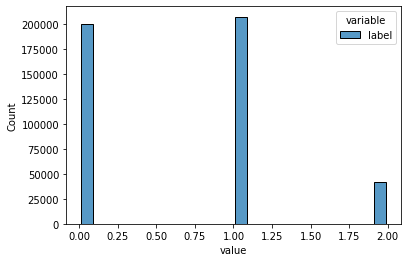

In [7]:
# plot distribution of data lables
sns.histplot(data_df[['label']].melt(), x='value', hue='variable',
             multiple='dodge', shrink=.75, bins=20);


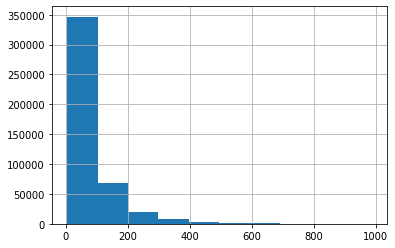

In [8]:
# plot distribution of text_lenth
data_df['text_length'].hist()

In [9]:
stopwords_list = stopwords.words('english')

def clean_text(text, lowercase=True, stop_words=True, links=True, numbers=True):
    text = text.replace("\\r", "")
    if lowercase:
        text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    if links:
        text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    if numbers:
       text = re.sub('\w*\d\w*', '', text)
    if stop_words:
        text = " ".join([word for word in text.split() if word not in stopwords_list])
    return text

In [10]:
clean_text("Hi i am amir, i'm a st5ent in this https://google.com", lowercase=False, stop_words=False)

'Hi i am amir im a  in this '

In [11]:
data_df['text_clean'] = data_df['text'].progress_apply(lambda text: clean_text(text))

  0%|          | 0/450000 [00:00<?, ?it/s]

In [12]:
data_df.head()

,title,body,label,text,text_length,text_clean
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1,y-zoom piano roll a y-zoom on the piano roll w...,12,yzoom piano roll yzoom piano roll would useful
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0,buggy behavior in selection ! screenshot from ...,13,buggy behavior selection screenshot
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1,"auto update feature hi,\r \r great job so far,...",35,auto update feature hi great job far saenzrami...
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1,filter out noisy endpoints in logs i think we ...,23,filter noisy endpoints logs think stop logging...
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0,enable pid on / pid off alarm actions for ardu...,291,enable pid pid alarm actions expected behavior...


## Ktrain

In [13]:
class_names = ['Bug', 'Feature', 'Question']

In [14]:
label_encoder = LabelEncoder()

X = data_df['text_clean'].values
y = label_encoder.fit_transform(data_df['label'])

In [15]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


In [ ]:
# build, train, and validate model (Transformer is wrapper around transformers library)

MODEL_NAME = 'bert-base-uncased'  # replace this with model of choice
transformer_model = text.Transformer(MODEL_NAME, maxlen=500, class_names=class_names)
trn = transformer_model.preprocess_train(X_train, y_train)
val = transformer_model.preprocess_test(X_val, y_val)
classifier_model = transformer_model.get_classifier()
learner = ktrain.get_learner(classifier_model, train_data=trn, val_data=val, batch_size=6)
learner.fit_onecycle(5e-5, 4)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 40
	95percentile : 119
	99percentile : 212


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 41
	95percentile : 120
	99percentile : 215


Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/4
10023/45000 [=====>........................] - ETA: 12:33:02 - loss: 0.6029 - accuracy: 0.7665

In [ ]:
tst = transformer_model.preprocess_test(X_test, y_test)
learner.validate(val_data=tst, class_names=transformer_model.get_classes()) # class_names must be string values